# Sampling Parameters

In this tutorial we explore the mechanisms for sampling the parameters used to simulate physical objects.

## Graph State

All information about a given simulation’s parameterization is stored in a `GraphState` object. This includes not only the settings of the physical object being simulated, such as its redshift, but also parameters of prior distributions and internal bookkeeping values. Most users will not need to interact directly with the `GraphState` object, but we provide a quick overview here for completeness.

Users can think of the `GraphState` as a nested dictionary where parameters are indexed by two levels. First, the node name or identifier tells the code which part of the simulation the parameter belongs to. This level of identification is necessary to allow different stages to use parameters with the same name. Second, the parameter name defines the actual parameter name.

As a concrete example, let’s look at a static object with a parameter for brightness.  We use the `sample_parameters()` function to generate a `GraphState`.

In [1]:
from tdastro.sources.basic_sources import StaticSource
import numpy as np

source = StaticSource(brightness=10.0, node_label="my_static_source")
state = source.sample_parameters()
print(state)

my_static_source:
    ra: None
    dec: None
    redshift: None
    t0: None
    distance: None
    brightness: 10.0


You can see the `GraphState` object contains an entry for our single node ("my_static_source") with subentries for all the parameters. Even though we only set a single parameter (brightness), the `StaticSource` object contains a series of other parameters that are inherited from the `PhysicalObject` base class such as ra, dec, and redshift. Parameters that are not set use a given default value.

It is important to note that the `StaticSource` object itself is stateless. We do not store any of the parameter information internally. Instead the `GraphState` object must be passed in for all computations. This enforces internal consistency between the parameters and allows for distributed computation.

### Multiple Samples

`GraphState` objects also support the storage of multiple samples with a third layer of nesting.

In [2]:
state = source.sample_parameters(num_samples=5)
print(state)

my_static_source:
    ra: [None None None None None]
    dec: [None None None None None]
    redshift: [None None None None None]
    t0: [None None None None None]
    distance: [None None None None None]
    brightness: [10. 10. 10. 10. 10.]


where each (node name, parameter name) pair now maps to an array of samples. Individual values for a single sample and parameter can be accessed with array notation:

In [3]:
state["my_static_source"]["brightness"][2]

10.0

The i-th entires of each parameter represent a single sampling of parameter space and are mutually consistent. 

**Note**: Care must be taken when writing code that directly accesses the `GraphState` object as it will return scalars when it stores a single value and arrays otherwise.

We can extract a single sample of all parameters with the `extract_single_sample()` function.

In [4]:
print(state.extract_single_sample(2))

my_static_source:
    ra: None
    dec: None
    redshift: None
    t0: None
    distance: None
    brightness: 10.0


### Alternate Accessors

You can also use a `ParameterizedNode` object to extract its own parameters without knowing the node's name.  The function `get_local_params()` return a dictionary of all parameters for this node. And the function `get_param()` looks up the value of a single parameter.  Both functions take a `GraphState` object.

In [5]:
nodes_params = source.get_local_params(state)
print(nodes_params)

brightness = source.get_param(state, "brightness")
print(f"brightness = {brightness}")

{'ra': array([None, None, None, None, None], dtype=object), 'dec': array([None, None, None, None, None], dtype=object), 'redshift': array([None, None, None, None, None], dtype=object), 't0': array([None, None, None, None, None], dtype=object), 'distance': array([None, None, None, None, None], dtype=object), 'brightness': array([10., 10., 10., 10., 10.])}
brightness = [10. 10. 10. 10. 10.]


## Parameterized Nodes

Parameters are generated and used by `ParameterizedNode` objects. This allows us to link the nodes (and their variables) together and sample them as a single block. The `StaticSource` object we used above is an example of a `ParameterizedNode`; it takes input parameters and operates on them. Other `ParameterizedNode` classes can be used to generate parameters from a given distribution or compute a new parameter from a combination of input parameters. 

Consider the `NumpyRandomFunc` class which wraps numpy’s random number generators. This class takes the name of the distribution and input parameters specific to that distribution. It output a parameter (by default called "function_node_result") from that distribution.

In [6]:
from tdastro.math_nodes.np_random import NumpyRandomFunc

brightness_func = NumpyRandomFunc("uniform", low=11.0, high=15.5)
state = brightness_func.sample_parameters(num_samples=10)
print(state)

NumpyRandomFunc:uniform_0:
    low: [11. 11. 11. 11. 11. 11. 11. 11. 11. 11.]
    high: [15.5 15.5 15.5 15.5 15.5 15.5 15.5 15.5 15.5 15.5]
    function_node_result: [12.74785971 14.74630085 15.36044308 11.44625128 14.33476941 15.42223101
 14.01426652 11.95790817 11.61977022 11.89804738]


Here we can see that "low" and "high" are stored in the `GraphState` as input parameters along with the sampled values (which are saved as "function_node_result").

## Chaining Nodes

To be useful, we need to be able to feed the output parameter of one node into the input parameter of another node. This allows us to create a statistical graph of parameters.

For example we could create a `StaticSource` node where the brightness is sampled from the a Gaussian distribution.  For nodes that produce a single output value (like our `NumpyRandomFunc` node), we can do this directly by using the node object in the arguments. This links the output of that node to the given input parameter.

In [7]:
brightness_dist = NumpyRandomFunc("normal", loc=20.0, scale=2.0, node_label="brightness_dist")
source = StaticSource(brightness=brightness_dist, node_label="test_source")
state = source.sample_parameters(num_samples=10)
print(state)

test_source:
    ra: [None None None None None None None None None None]
    dec: [None None None None None None None None None None]
    redshift: [None None None None None None None None None None]
    t0: [None None None None None None None None None None]
    distance: [None None None None None None None None None None]
    brightness: [21.92308972 21.43011502 18.96839401 17.87594313 21.07424408 18.48863681
 19.11054623 20.34066555 20.07337429 20.04212202]
brightness_dist:
    loc: [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
    scale: [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
    function_node_result: [21.92308972 21.43011502 18.96839401 17.87594313 21.07424408 18.48863681
 19.11054623 20.34066555 20.07337429 20.04212202]


Note that when we print out the `GraphState` now, it includes information for both the `NumpyRandomFunc` and `StaticSource` source nodes. It is effectively capturing the full state of the system.

Each instance of the source's brightness is sampled from a Gaussian distribution with the corresponding "loc" and "scale" parameters. This is an important distinction from how we might normally think of input arguments in Python. `StaticSource` is not getting a single value of "brightness" in its constructor, but rather is being told where to get a new value of "brightness" for each sampling run.

We can demonstrate the importance of consistency by adding a third level of chaining. We generate the Gaussian's mean from a prior distribution.

In [8]:
brightness_mean = NumpyRandomFunc("uniform", low=20.0, high=30.0, node_label="brightness_mean")
brightness_dist = NumpyRandomFunc("normal", loc=brightness_mean, scale=2.0, node_label="gauss")
source = StaticSource(brightness=brightness_dist, node_label="test")
state = source.sample_parameters(num_samples=10)
print(state)

test:
    ra: [None None None None None None None None None None]
    dec: [None None None None None None None None None None]
    redshift: [None None None None None None None None None None]
    t0: [None None None None None None None None None None]
    distance: [None None None None None None None None None None]
    brightness: [27.87941373 26.27270251 20.85245316 21.83705717 29.9092699  28.0359353
 22.54088129 22.74090058 30.11555459 26.02505939]
brightness_mean:
    low: [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
    high: [30. 30. 30. 30. 30. 30. 30. 30. 30. 30.]
    function_node_result: [27.39309841 26.54828948 22.54943064 21.77170069 29.60758106 28.42283157
 22.15588355 24.77466965 29.04597832 23.86598089]
gauss:
    loc: [27.39309841 26.54828948 22.54943064 21.77170069 29.60758106 28.42283157
 22.15588355 24.77466965 29.04597832 23.86598089]
    scale: [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
    function_node_result: [27.87941373 26.27270251 20.85245316 21.83705717 29.9092699  28.03

Now during each sampling instance we first generate a mean for our Gaussian distribution and then generate a brightness given that mean parameter.

Text(0, 0.5, 'Sampled Brightness')

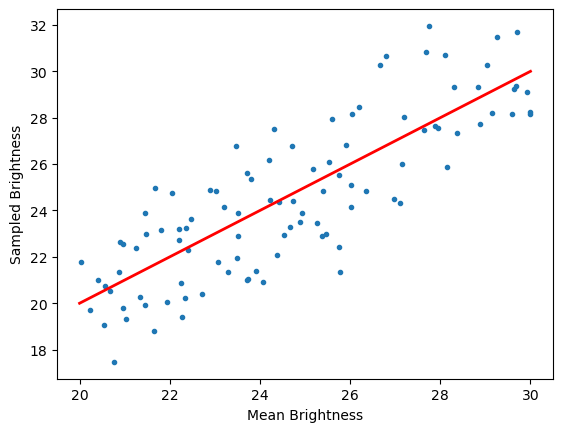

In [9]:
import matplotlib.pyplot as plt

state = source.sample_parameters(num_samples=100)

mean_vals = state["gauss"]["loc"]
brightness_vals = state["test"]["brightness"]
plt.plot(mean_vals, brightness_vals, marker=".", linewidth=0)
plt.plot([20.0, 30.0], [20.0, 30.0], linewidth=2, color="red")
plt.xlabel("Mean Brightness")
plt.ylabel("Sampled Brightness")

## Function Nodes

Sampling functions, such as those provided by numpy, are only one type of function that we might want to use to generate parameters. We might want to sample from other functions or apply a mathematical transform to multiple input parameters to compute a new parameter. For example consider the case of computing the `distmod` parameter from `redshift`. We can do this using the information about the cosmology, such as provided by astropy's `FlatLambdaCDM` class:

In [10]:
from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(H0=73.0, Om0=0.3)
redshifts = np.array([0.1, 0.2, 0.3])
distmods = cosmo.distmod(redshifts).value
print(distmods)

[38.22408047 39.8651567  40.86433594]


Importantly, you can use a `FunctionNode` that takes input parameter(s) and produces output parameter(s) during the generation. `FunctionNode` is a subclass of `ParameterizedNode` that wraps the functionality of collecting the inputs, running the computations, and storing the output.

As a simple example, let's create a `FunctionNode` that computes y = m * x + b.

In [11]:
from tdastro.base_models import FunctionNode


def _linear_eq(x, m, b):
    """Compute y = m * x + b"""
    return m * x + b


func_node = FunctionNode(
    _linear_eq,  # First parameter is the function to call.
    x=NumpyRandomFunc("uniform", low=0.0, high=10.0),
    m=5.0,
    b=-2.0,
)
print(func_node.sample_parameters(num_samples=1))

NumpyRandomFunc:uniform_1:
    low: 0.0
    high: 10.0
    function_node_result: 1.1967760057743948
FunctionNode:_linear_eq_0:
    x: 1.1967760057743948
    m: 5.0
    b: -2.0
    function_node_result: 3.9838800288719742


The first parameter of the function node is the function to evaluate, such as our linear equation above. Each input into that function **must** be included as a named parameter during the `FunctionNode` definition, such as `x`, `m`, and `b` above. If any of the input parameters are missing the code will give an error.

Here we use constants for `m` and `b` so we use the same linear formulation for each sample. Only the value of `x` changes. However we could have also used function nodes, including sampling functions, to set `m` and `b`. In that case it is important to remember that each of our results sample will be the result of a sampling of all the variable parameters.

It would be tiresome to manually generate a `FunctionNode` object or class for every small mathematical function we need to use. As such TDAstro also provides the `BasicMathNode`, which will take a string and (safely) compile the mathematical expression into a function.  It can support most of the basic math functions that are common to the math, numpy, and jax.numpy libraries, including addition, subtraction, multiplication, division, logarithms, exponents/powers, degree/radian conversions, trig functions, absolute value, ceiling, and floor.

In [12]:
from tdastro.math_nodes.basic_math_node import BasicMathNode

math_node = BasicMathNode("a + b", a=5.0, b=10.0)
print(math_node.sample_parameters(num_samples=1))

math_node2 = BasicMathNode("cos(radians(a)) * abs(b) - c", a=45.0, b=-10.0, c=1.0)
print(math_node2.sample_parameters(num_samples=1))

BasicMathNode:eval_func_0:
    a: 5.0
    b: 10.0
    function_node_result: 15.0
BasicMathNode:eval_func_0:
    a: 45.0
    b: -10.0
    c: 1.0
    function_node_result: 6.0710678118654755


A full list of supported functions can be found with the `list_functions()` function.

In [13]:
BasicMathNode.list_functions()

['abs',
 'acos',
 'acosh',
 'asin',
 'asinh',
 'atan',
 'atan2',
 'cos',
 'cosh',
 'ceil',
 'degrees',
 'deg2rad',
 'e',
 'exp',
 'fabs',
 'floor',
 'log',
 'log10',
 'log2',
 'max',
 'min',
 'pi',
 'pow',
 'power',
 'radians',
 'rad2deg',
 'sin',
 'sinh',
 'sqrt',
 'tan',
 'tanh',
 'trunc']

## Linked (Copied) Parameters

Often the values of one node might depend on the values of another that are not the result of a function. A great case of this is a source/host pair where the location of the source depends on that of the host. We can access another node’s sampled parameters using a `.` notation: `{model_object}.{parameter_name}`

In [ ]:
ra_node = NumpyRandomFunc("uniform", low=0.0, high=360.0)
host = StaticSource(brightness=15.0, ra=ra_node, dec=2.0, node_label="host")
source = StaticSource(brightness=10.0, ra=host.ra, dec=host.dec, node_label="source")
state = source.sample_parameters(num_samples=100)

plt.plot(state["host"]["ra"], state["source"]["ra"], marker="o", linewidth=0)
plt.plot([0.0, 360.0], [0.0, 360.0], linewidth=1, alpha=0.5, color="red")
plt.xlabel("Host RA")
plt.ylabel("Source RA")

Again it is important to remember that the `ParameterizedNode`s are stateless and these parameters are not values stored in the Python objects themselves. In the creation of the `source` object, we are **not** setting its ra argument to the value stored in `host.ra`. Rather we are providing the new `source` node with instructions that, during each sample, it should copy the corresponding value from the `host` node's ra value.

This means that we can combine the node-parameter references with functional nodes to perform actions such as sampling with noise.

Here we generate the host's (RA, dec) from a uniform patch of the sky and then generate the source's (RA, dec) using a Gaussian distribution centered on the host's position. For each sample the host and source should be close, but not necessarily identical.

In [ ]:
host = StaticSource(
    brightness=15.0,
    ra=NumpyRandomFunc("uniform", low=10.0, high=150.0),
    dec=NumpyRandomFunc("uniform", low=-10.0, high=10.0),
    node_label="host",
)

source = StaticSource(
    brightness=100.0,
    ra=NumpyRandomFunc("normal", loc=host.ra, scale=0.1),
    dec=NumpyRandomFunc("normal", loc=host.dec, scale=0.1),
    node_label="source",
)
state = source.sample_parameters(num_samples=100)

ra_diffs = state["source"]["ra"] - state["host"]["ra"]
dec_diffs = state["source"]["dec"] - state["host"]["dec"]

ax = plt.figure().subplots(1, 2)
ax[0].hist(ra_diffs, bins=20)
ax[0].set_xlabel("RA Difference")

ax[1].hist(dec_diffs, bins=20)
ax[1].set_xlabel("Dec Difference")

Again we can access all the information for a single sample. Here we see the full state tracked by the system. In addition to the `host` and `source` nodes we created, the information for the functional nodes is tracked.

In [ ]:
single_sample = state.extract_single_sample(0)
print(str(single_sample))

It is interesting to note that functional nodes themselves are parameterized nodes, allowing for more complex forms of chaining. For example we could set the `low` parameter from one of the `NumpyRandomFunc`s from another function node. This allows us to specify priors and comlex distributions.

Similarly we can now make the input parameters of one node depend on a function of parameters from other nodes. We can arbitrarily chain the computations.

In [ ]:
# Create a host galaxy with a random brightness.
host = StaticSource(
    brightness=NumpyRandomFunc("uniform", low=1.0, high=5.0),
    node_label="host",
)

# Create the brightness of the source as a uniformly sampled foreground brightness
# added to the 80% of the host's brightness (background).
source_brightness = BasicMathNode(
    "0.8 * val1 + val2",
    val1=host.brightness,
    val2=NumpyRandomFunc("uniform", low=1.0, high=2.0),
    node_label="plus_80percent",
)

source = StaticSource(
    brightness=source_brightness,
    node_label="source",
)
state = source.sample_parameters(num_samples=10)
print(f"Host Brightness: {state['host']['brightness']}")
print(f"Source Brightness: {state['source']['brightness']}")

While we use a `BasicMathNode` to compute the combined brightness to illustrate chaining above, we would often prefer to use a `MultiSourceModel` to represent a combination of fluxes.

## Conclusion

TDAstro provides significant flexibility in how parameters can be defined, allowing a users to create complex statistical models. The specification is meant to be familiar to users of Python by using direct assignment (`argument=object`) for functions and the `.` notation (`argument=object.parameter`) for references parameters. Internally TDAstro manages the various references so that each new sample regenerates the instances of the all the parameters in the model in a statistically consistent way.

This tutorial only provides an introduction to the full sampling system, which can support additional operations including:

  * Multi-output functions
  * Efficient vectorized computations for large numbers of samples
  * Seeding of random number generation and isolation of subgraphs for testing

These concepts (and others) will be demonstrated in future tutorials and in the code.

